---
# I. Module imports

In [1]:
%load_ext cython
%matplotlib inline
%load_ext autoreload
%autoreload 2

from __future__ import division

import sys
sys.path.append('src')
sys.path.append('src/util')

import numpy as np
np.set_printoptions(edgeitems=5, precision=5)

from matplotlib import pyplot as plt

import pandas as pd
pd.set_option('display.max_rows', 10)
pd.set_option('precision', 9)

# import pint
import time
import codetimer as ct

---
## Plotting function for testing 2D RNG correlations

In [44]:
def quickplot(distr, Nx=20000, Ny=100, sigma=2.0, seed=123456, workers=1, seaborn=True):
    posterior = np.array(distr(Nx=Nx, Ny=Ny, sigma=sigma, seed=seed, workers=workers))
    xlim = [-4*sigma, 4*sigma]
    ylim = [-4*sigma, 4*sigma]   
    if seaborn:
        import seaborn as sns
        sns.set_style("darkgrid")
        sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
        posterior = pd.DataFrame(posterior, columns=['x', 'y'])
        sns.jointplot('x', 'y', data=posterior, kind="hex", color="#4CB391", xlim=xlim, ylim=ylim)
    else:
        x = posterior[:, 0]
        y = posterior[:, 1]
        plt.hexbin(x, y)
        plt.xlim(xlim)
        plt.ylim(ylim)
        plt.gca().set_aspect(1)
    plt.tight_layout()

In [45]:
def quickplot2(distr, Nx=20000, Ny=100, sigma=2.0, seed=123456, workers=1, seaborn=True, ax=None):
    posterior = np.array(distr(Nx=Nx, Ny=Ny, sigma=sigma, seed=seed, workers=workers))
    xlim = [-4*sigma, 4*sigma]
    ylim = [-4*sigma, 4*sigma]   
    if seaborn:
        import seaborn as sns
        sns.set_style("darkgrid")
        sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
        posterior = pd.DataFrame(posterior, columns=['x', 'y'])
        sns.jointplot('x', 'y', data=posterior, kind="hex", color="#4CB391", xlim=xlim, ylim=ylim)
    else:
        x = posterior[:, 0]
        y = posterior[:, 1]
        ax.hexbin(x, y)
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        ax.set_aspect(1)
    plt.tight_layout()

---

---
# Gaussian RNGs

---
## (0) NumPy RNG

In [3]:
import numpy.random as npr

def gauss_numpy(Nx=20000, Ny=10, sigma=2.0):
    return npr.normal(0, sigma, (Nx, Ny))

In [4]:
%%cython -c=-march=native -c=-Ofast -c=-ffast-math

import numpy as np
cimport numpy as np

cimport cython

@cython.boundscheck(False)
@cython.wraparound(False)
cpdef double[:,::1] gauss_numpy_slow(int Nx=20000, int Ny=10, double mu=0.0, double sigma=2.0):
    cdef double[:,::1] nparr_view
    cdef int i, j
    cdef int NX, NY
    
    nparr = np.empty((Nx, Ny), dtype=np.dtype("double"))
    nparr_view = nparr
    NX = nparr_view.shape[0]
    NY = nparr_view.shape[1]
    
    for i in range(Nx):
        for j in range(Ny):
            nparr_view[i, j] = np.random.normal(mu, sigma, 1)
    return nparr

def gauss_numpy_ref(int Nx=20000, int Ny=10, double mu=0.0, double sigma=2.0):
    cdef int i
    cdef int NX
    
    nparr = np.empty((Nx, Ny), dtype=np.dtype("double"))
    NX = nparr.shape[0]
    
    for i in range(NX):
        nparr[i, :] = np.random.normal(mu, sigma, Ny)
    return nparr

---
## (1) Custom GaussianRNG

Based on MT19337 from the "random" C++ library: 
* [`std::mt19337` class for PRNG](http://www.cplusplus.com/reference/random/mt19937/)
* [`std::normal_distribution` class template](http://www.cplusplus.com/reference/random/normal_distribution/)

**Notes**:
  * doesn't use pointers for the wrapper extension type (which would probably be better)

In [5]:
%%cython -f --cplus -c=-march=native -c=-fopenmp --link-args=-fopenmp -lgomp -c=-funroll-loops -I/home/seanseyler/Library/miniconda2/include -lgsl -lgslcblas
# distutils: language = c++
# distutils: extra_compile_args = -std=c++11
import numpy as np
cimport numpy as np
import cython
from cython.parallel cimport parallel
from cython.parallel import prange, threadid
cimport openmp

###################################################################################
cdef extern from "<random>" namespace "std" nogil:
    cdef cppclass mt19937 nogil:
        mt19937() # we need to define this constructor to stack allocate classes in Cython
        mt19937(unsigned int seed) # not worrying about matching the exact int type for seed
    
    cdef cppclass uniform_real_distribution[T] nogil:
        uniform_real_distribution()
        uniform_real_distribution(T a, T b)
        T operator()(mt19937 gen)

    cdef cppclass normal_distribution[T] nogil:
        normal_distribution()
        normal_distribution(T mean, T stddev)
        T operator()(mt19937 gen)
        
###################################################################################
cdef class GaussianRNG:
    cdef mt19937 _genptr
    cdef normal_distribution[double] distribution
    cdef double mu, sigma
    
    def __cinit__(self, double mu, double sigma, unsigned long seed=123456):
        self.mu = mu
        self.sigma = sigma
        self.distribution = normal_distribution [double](mu, sigma)
        self._genptr = mt19937(seed)
    
    cdef void initialize(self, unsigned long seed) nogil:
        self._genptr = mt19937(seed)

    cdef double generate(self) nogil:
        return self.distribution(self._genptr)

@cython.boundscheck(False)
@cython.wraparound(False)        
def gauss_custom(long Nx, long Ny, double mu=0.0, double sigma=2.0, int seed=123456, int workers=1):
    cdef:
        long pseed
        GaussianRNG rng = GaussianRNG(mu, sigma)
        double [:,::1] nparr_view
        long NX, NY
        long i, j

    nparr = np.empty((Nx, Ny), dtype=np.dtype("double"))
    nparr_view = nparr
    NX = nparr_view.shape[0]
    NY = nparr_view.shape[1]

    with nogil, parallel(num_threads=workers):
        pseed = seed + openmp.omp_get_thread_num()
#         with gil:
#             print 'thread={} has pseed={}'.format(openmp.omp_get_thread_num(), pseed)
        rng.initialize(pseed)
        for i in prange(NX, schedule='static', chunksize=1):
            for j in range(NY):
                nparr_view[i,j] = rng.generate()
                nparr_view[i,j] = rng.generate()
    return nparr

---
## (2) Parallelization based directly on calling mt19337

In [6]:
%%cython --compile-args=-fopenmp --link-args=-fopenmp --force
# distutils: language = c++
# distutils: extra_compile_args = -std=c++11
import cython
import numpy as np
cimport numpy as np
from cython.parallel cimport parallel
from cython.parallel import prange, threadid
cimport openmp

###################################################################################
cdef extern from "<random>" namespace "std" nogil:
    cdef cppclass mt19937:
        mt19937() # we need to define this constructor to stack allocate classes in Cython
        mt19937(unsigned int seed) # not worrying about matching the exact int type for seed
    
    cdef cppclass uniform_real_distribution[T]:
        uniform_real_distribution()
        uniform_real_distribution(T a, T b)
        T operator()(mt19937 gen)

    cdef cppclass normal_distribution[T] nogil:
        normal_distribution()
        normal_distribution(T mean, T stddev)
        T operator()(mt19937 gen)

###################################################################################
@cython.boundscheck(False)
@cython.wraparound(False)        
def gauss_mt19337(long Nx, long Ny, double mu=0.0, double sigma=2.0, int seed=123456, int workers=1):
    cdef:
        long pseed
        mt19937 gen
        normal_distribution[double] dist = normal_distribution[double](mu, sigma)
        double [:,::1] nparr_view
        long NX, NY
        long i, j

    nparr = np.empty((Nx, Ny), dtype=np.dtype("double"))
    nparr_view = nparr
    NX = nparr_view.shape[0]
    NY = nparr_view.shape[1]

    with nogil, parallel(num_threads=workers):
        pseed = seed + openmp.omp_get_thread_num()
#         with gil:
#             print 'thread={} has pseed={}'.format(openmp.omp_get_thread_num(), pseed)
        gen = mt19937(pseed)
        for i in prange(NX, schedule='static', chunksize=1):
            for j in range(NY):
                nparr_view[i,j] = dist(gen)
                nparr_view[i,j] = dist(gen)
    return nparr

---
## (3) CythonGSL

In [7]:
%%cython --cplus -c=-march=native -c=-Ofast -c=-ffast-math -I/home/sseyler/Library/miniconda2/include -lgsl -lgslcblas -c=-fopenmp --link-args=-fopenmp -lgomp
#%%cython --cplus -c=-march=native -c=-Ofast -c=-ffast-math -I/home/seanseyler/Library/miniconda2/include -lgsl -lgslcblas -c=-fopenmp --link-args=-fopenmp -lgomp
#cython: cdivision=True
import cython
import numpy as np
cimport numpy as np
from cython.parallel cimport parallel
from cython.parallel import prange, threadid
cimport openmp
from cython_gsl cimport *

###################################################################################
cdef class GaussianRNG_CythonGSL:
    cdef gsl_rng *r
    cdef double mu, sigma
    cdef long seed
    
    def __cinit__(self, double mu, double sigma, long seed=123456):
        self.mu = mu
        self.sigma = sigma
        self.r = gsl_rng_alloc(gsl_rng_mt19937)

    cdef void set_seed(self, unsigned long seed) nogil:
        self.seed = seed
        gsl_rng_set(self.r, seed)
    
    cdef void alloc(self, gsl_rng_type *rng_type) nogil:
        self.r = gsl_rng_alloc(rng_type)

    cdef double generate(self) nogil:
        return gsl_ran_gaussian(self.r, self.sigma)

@cython.boundscheck(False)
@cython.wraparound(False)
cpdef double[:,::1] gauss_cythongsl(int Nx=20000, int Ny=10, double sigma=2.0, int seed=123456, int workers=1):
    cdef long pseed
    cdef double[:,::1] nparr_view
    cdef int i, j
    cdef int NX, NY
    cdef gsl_rng *r  # will still work without this declaration...
    
    nparr = np.empty((Nx, Ny), dtype=np.dtype("double"))
    nparr_view = nparr
    NX = nparr_view.shape[0]
    NY = nparr_view.shape[1]
    
    with nogil, parallel(num_threads=workers):
        pseed = seed + openmp.omp_get_thread_num()
#         with gil:
#             print 'thread={} has pseed={}'.format(openmp.omp_get_thread_num(), pseed)
        r = gsl_rng_alloc(gsl_rng_mt19937)
        gsl_rng_set(r, pseed)

        for i in prange(NX, schedule='static', chunksize=1):
            for j in range(NY):
                nparr_view[i, j] = gsl_ran_gaussian(r, sigma)
                nparr_view[i, j] = gsl_ran_gaussian(r, sigma)
    return nparr_view

---
## (4) Fully custom GaussianRNG based on MT19337 and user-defined Gaussian RNGs

In [8]:
%%cython --cplus -c=-march=native -c=-fopenmp --link-args=-fopenmp -lgomp

from libc.stdlib cimport rand, RAND_MAX
from libcpp.limits cimport numeric_limits
from libc.math cimport log, sqrt, sin, cos
import numpy as np
cimport numpy as np
import cython
from cython.parallel import prange, parallel, threadid

cpdef double uniform_rv_raw():
    cdef double r = rand()
    return r / RAND_MAX

cdef class UniformRNG:
    cdef long seed
    cdef double iRAND_MAX
    cdef double rv
    
    def __cinit__(self, long seed):
        self.seed = seed
        self.iRAND_MAX = 1.0/RAND_MAX

    cdef double generate(self) nogil:
        return 0

cdef class FastUniformRNG(UniformRNG):
    cdef double generate(self) nogil:
        self.rv = rand() * self.iRAND_MAX
        return self.rv


cdef class GaussianRNG:
    cdef double epsilon, two_pi
    cdef double mu, sigma
    cdef double z0, z1
    cdef UniformRNG random_uniform
    
    def __cinit__(self, double mu, double sigma, long seed):
        self.epsilon = numeric_limits[double].min()
        self.two_pi = 2.0*3.14159265358979323846
        self.seed = seed
        self.mu = mu
        self.sigma = sigma
        self.random_uniform = FastUniformRNG()
        
    cpdef double generate(self):
        return 0


cdef class BoxMuellerGaussianRNG(GaussianRNG):
    cpdef double generate(self):       
        cdef double sqrt_minus_two_log_u, two_pi_v
        cdef double u, v
        while(u <= self.epsilon):
            u = self.random_uniform.generate()
            v = self.random_uniform.generate()
        
        sqrt_minus_two_log_u = sqrt(-2.0 * log(u))
        two_pi_v = self.two_pi * v
        self.z0 = sqrt_minus_two_log_u * cos(two_pi_v)
        self.z1 = sqrt_minus_two_log_u * sin(two_pi_v)
        return self.z0 * self.sigma + self.mu

    
cdef class MarsagliaPolarGaussianRNG(GaussianRNG):
    cpdef double generate(self):
        cdef double u, v
        cdef double s = 2.0
        while(s >= 1.0 or s == 0):
            u = 2.0 * self.random_uniform.generate() - 1.0
            v = 2.0 * self.random_uniform.generate() - 1.0
            s = u*u + v*v
        
        s = sqrt( (-2.0 * log(s)) / s)
        self.z0 = s * u
        self.z1 = s * v
        return self.z0 * self.sigma + self.mu

---

In [65]:
arr_custom = np.array(gauss_custom(Nx=8, Ny=1, sigma=1, seed=123456, workers=1))
arr_custom_omp2 = np.array(gauss_custom(Nx=8, Ny=1, sigma=1, seed=123456, workers=2))
arr_custom_omp4 = np.array(gauss_custom(Nx=8, Ny=1, sigma=1, seed=123456, workers=4))
np.hstack((arr_custom, arr_custom_omp2, arr_custom_omp4))

array([[ 0.03568, -0.59198,  0.2307 ],
       [ 0.7191 , -1.06652,  0.2307 ],
       [ 0.61933,  0.42129,  0.2307 ],
       [-0.64158, -1.24203,  0.2307 ],
       [-0.11024, -1.06652,  0.17637],
       [ 0.50111, -0.89976,  0.17637],
       [-0.33789,  0.21971,  0.17637],
       [ 0.9838 ,  0.53963,  0.87564]])

In [66]:
arr_mt19337 = np.array(gauss_mt19337(Nx=8, Ny=1, sigma=1, seed=123456, workers=1))
arr_mt19337_omp2 = np.array(gauss_mt19337(Nx=8, Ny=1, sigma=1, seed=123456, workers=2))
arr_mt19337_omp4 = np.array(gauss_mt19337(Nx=8, Ny=1, sigma=1, seed=123456, workers=4))
np.hstack((arr_mt19337, arr_mt19337_omp2, arr_mt19337_omp4))

array([[ 0.03568,  0.03568,  0.03568],
       [ 0.7191 , -0.59198, -0.59198],
       [ 0.61933,  0.7191 ,  0.45253],
       [-0.64158,  0.42129,  2.46592],
       [-0.11024,  0.61933,  0.7191 ],
       [ 0.50111, -1.06652,  0.42129],
       [-0.33789, -0.64158,  1.74646],
       [ 0.9838 ,  0.21971, -1.66566]])

In [64]:
arr_cythongsl = np.array(gauss_cythongsl(Nx=8, Ny=1, sigma=1, seed=123456, workers=1))
arr_cythongsl_omp2 = np.array(gauss_cythongsl(Nx=8, Ny=1, sigma=1, seed=123456, workers=2))
arr_cythongsl_omp4 = np.array(gauss_cythongsl(Nx=8, Ny=1, sigma=1, seed=123456, workers=4))
np.hstack((arr_cythongsl, arr_cythongsl_omp2, arr_cythongsl_omp4))

array([[ 0.88355,  0.88355,  0.88355],
       [ 0.63161,  1.49477,  1.49477],
       [-2.00211,  0.63161,  1.75709],
       [-0.8364 , -0.51053, -0.16324],
       [ 0.54726, -2.00211,  0.63161],
       [-0.43201,  2.1947 , -0.51053],
       [-0.49382, -0.8364 ,  0.21389],
       [ 0.10397, -1.81753, -0.03214]])

---
# Speed testing

In [12]:
N = int(1e6)

### Generating arrays

#### (0) Numpy

In [185]:
%timeit gauss_numpy(Nx=N, Ny=10)
%timeit gauss_numpy_ref(Nx=N, Ny=10)
%timeit gauss_numpy_slow(Nx=N, Ny=10)

1 loop, best of 3: 626 ms per loop
1 loop, best of 3: 3.79 s per loop
1 loop, best of 3: 27.2 s per loop


#### (1) Custom GaussianRNG based on MT19337

In [11]:
%timeit gauss_custom(Nx=N, Ny=10, workers=1)
%timeit gauss_custom(Nx=N, Ny=10, workers=2)
%timeit gauss_custom(Nx=N, Ny=10, workers=4)

1 loop, best of 3: 601 ms per loop
1 loop, best of 3: 482 ms per loop
1 loop, best of 3: 464 ms per loop


In [12]:
%timeit gauss_mt19337(Nx=N, Ny=10, workers=1)
%timeit gauss_mt19337(Nx=N, Ny=10, workers=2)
%timeit gauss_mt19337(Nx=N, Ny=10, workers=4)

1 loop, best of 3: 554 ms per loop
1 loop, best of 3: 401 ms per loop
1 loop, best of 3: 375 ms per loop


In [12]:
%timeit gauss_cythongsl(Nx=N, Ny=10, workers=1)
%timeit gauss_cythongsl(Nx=N, Ny=10, workers=2)
%timeit gauss_cythongsl(Nx=N, Ny=10, workers=4)

1 loop, best of 3: 819 ms per loop
1 loop, best of 3: 448 ms per loop
1 loop, best of 3: 227 ms per loop


### Generating single RV

#### (0) Numpy

In [186]:
%timeit np.random.normal(0, 1, 1)

The slowest run took 28.02 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 3: 1.36 µs per loop


#### (1) Custom GaussianRNG based on MT19337

In [36]:
gauss_rng = GaussianRNG(0, 1)
%timeit -r5 gauss_rng.generate()

The slowest run took 74.79 times longer than the fastest. This could mean that an intermediate result is being cached.
10000000 loops, best of 5: 66.9 ns per loop


#### (2) Custom (version 2) GaussianRNG based on MT19337

In [ ]:
rng = BoxMuellerGaussianRNG(1.0, 1.0)
%timeit rng.generate()

In [ ]:
rng = MarsagliaPolarGaussianRNG(1.0, 1.0)
%timeit rng.generate()

#### (3) CythonGSL

In [ ]:
gauss_cgsl_rng = GaussianRNG_CythonGSL(0, 1, 123456)
%timeit -r5 gauss_cgsl_rng.generate()

---

---
# Correctness testing

In [15]:
import scipy as sp
import scipy.stats
from matplotlib.pyplot import imshow

In [12]:
def normaltest(arr, alpha=0.05):
    k2, p = scipy.stats.normaltest(arr.flatten())
    print("p = {:g}".format(p))
    if p < alpha:  # null hypothesis: x comes from a normal distribution
        print("The null hypothesis can be rejected")
    else:
        print("The null hypothesis cannot be rejected")

In [18]:
N = int(2e2)

---

In [30]:
arr_numpy = np.random.normal(0, 1, (N,N))
plt.figure(figsize=(12,6))
plt.imshow(arr_numpy)
normaltest(arr_numpy)

p = 0.250827
The null hypothesis cannot be rejected


p = 0.904037
The null hypothesis cannot be rejected


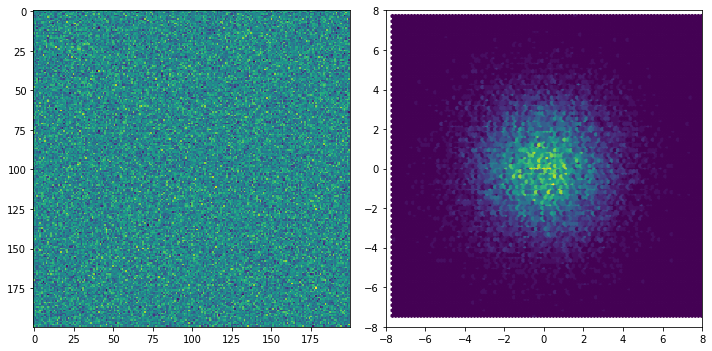

In [59]:
arr_mt19337_omp2 = np.array(gauss_mt19337(Nx=N, Ny=N, sigma=1, seed=123456, workers=2))
fig, axs = plt.subplots(1, 2, figsize=(10,5))
axs[0].imshow(arr_mt19337_omp2)
quickplot2(gauss_mt19337, Ny=2, sigma=2.0, workers=2, seed=123456, seaborn=False, ax=axs[1])
normaltest(arr_mt19337_omp2)

In [60]:
gauss_custom_omp2 = np.array(gauss_custom(Nx=N, Ny=N, sigma=1, seed=123456, workers=2))
fig, axs = plt.subplots(1, 2, figsize=(10,5))
axs[0].imshow(gauss_custom_omp2)
quickplot2(gauss_custom, Ny=2, sigma=2.0, workers=2, seed=123456, seaborn=False, ax=axs[1])
normaltest(gauss_custom_omp2)

p = 0.0451417
The null hypothesis can be rejected


p = 0.0150521
The null hypothesis can be rejected


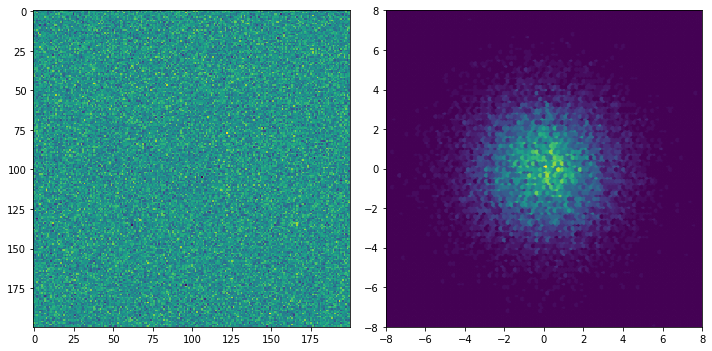

In [61]:
gauss_cythongsl_omp2 = np.array(gauss_cythongsl(Nx=N, Ny=N, sigma=1, seed=123456, workers=2))
fig, axs = plt.subplots(1, 2, figsize=(10,5))
axs[0].imshow(gauss_cythongsl_omp2)
quickplot2(gauss_cythongsl, Ny=2, sigma=2.0, workers=2, seed=123456, seaborn=False, ax=axs[1])
normaltest(gauss_cythongsl_omp2)

In [26]:
%%cython --cplus -c=-march=native -c=-Ofast -c=-ffast-math -I/home/sseyler/Library/miniconda2/include -lgsl -lgslcblas -c=-fopenmp --link-args=-fopenmp -lgomp
#%%cython --cplus -c=-march=native -c=-Ofast -c=-ffast-math -I/home/sseyler/Library/miniconda2/include -lgsl -lgslcblas -c=-fopenmp --link-args=-fopenmp -lgomp
#cython: cdivision=True

import cython
cimport cython
import numpy as np
cimport numpy as np

from cython.parallel import prange, parallel, threadid
from cython_gsl cimport *

cdef gsl_rng *r = gsl_rng_alloc(gsl_rng_mt19937)
gsl_rng_set(r, 123456)

@cython.boundscheck(False)
@cython.wraparound(False)
cpdef double[:,::1] gauss(int Nx=20000, int Ny=10, double sigma=2.0, int seed=123456, int workers=1):
    cdef int i, j
    cdef double[:,::1] samples = np.empty((Nx, Ny), dtype=np.float64)
    cdef int NX = samples.shape[0]
    cdef int NY = samples.shape[1]
#     gsl_rng_set(r, seed)

    for i in range(NX):
        for j in range(NY):
            samples[i, j] = gsl_ran_gaussian(r, sigma)
    return samples

@cython.boundscheck(False)
@cython.wraparound(False)
cpdef double[:,::1] gauss_omp(int Nx=20000, int Ny=10, double sigma=2.0, int seed=123456, int workers=1):
    cdef double[:,::1] samples = np.empty((Nx, Ny), dtype=np.float64)
    cdef int i, j
    cdef int NX = samples.shape[0]
    cdef int NY = samples.shape[1]
    
    with nogil, parallel(num_threads=workers):
        for i in prange(NX):
            for j in range(NY):
                samples[i, j] = gsl_ran_gaussian(r, sigma)
    return samples

p = 0.11491
The null hypothesis cannot be rejected


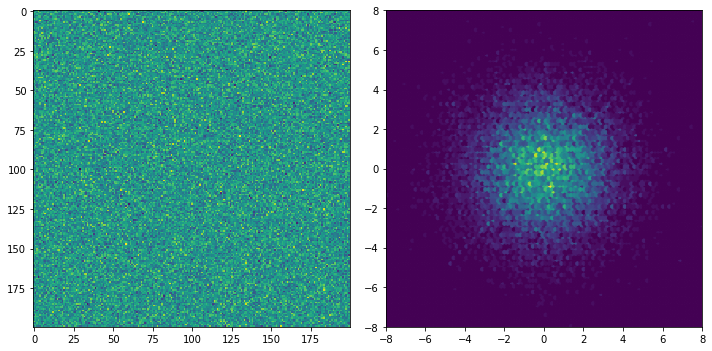

In [72]:
arr_omp = np.array(gauss_omp(Nx=N, Ny=N, sigma=1, seed=123456, workers=2))
fig, axs = plt.subplots(1, 2, figsize=(10,5))
axs[0].imshow(arr_omp)
quickplot2(gauss_omp, Ny=2, sigma=2.0, workers=2, seed=123456, seaborn=False, ax=axs[1])
normaltest(arr_omp)

### Basic MT19337

In [ ]:
quickplot(gauss_custom, Ny=2, sigma=2.0, workers=1, seed=123456)
quickplot(gauss_custom, Ny=2, sigma=2.0, workers=2, seed=123456)

### CythonGSL

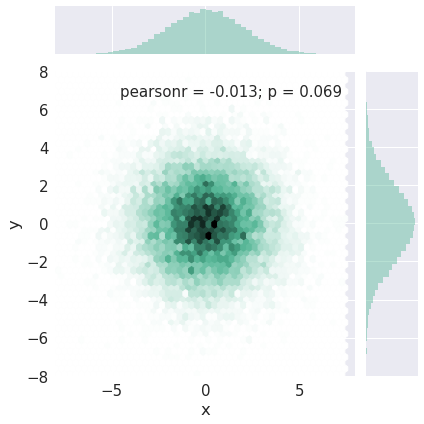

In [235]:
quickplot(gauss_mt19337, Ny=2, sigma=2.0, workers=1, seed=123456)
quickplot(gauss_mt19337, Ny=2, sigma=2.0, workers=2, seed=123456)

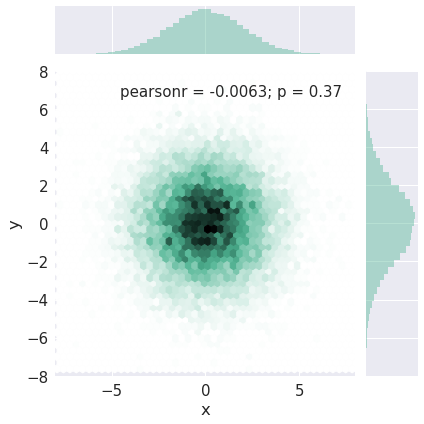

In [25]:
quickplot(gauss_cythongsl, Ny=2, sigma=2.0, workers=1, seed=123456)
quickplot(gauss_cythongsl, Ny=2, sigma=2.0, workers=2, seed=123456)